# Variational Quantum Eigensolver

In many real world applications and situations, finding the minimal eigenvalue of a matrix is an important task. In chemistry, the minimal eigenvalue of the Hermitian matrix that describes the behavior of a molecule is the ground state energy of the molecule. Phase estimation is a good candidate to solve this problem in the future, but the current hardware doesn't allow using phase estimation for this purpose.

For this reason, Peruzzo developed the varational quantum eigensolver which is able to estimate the ground state energy of a system using current hardware. 

**The problem**

Given a Hermitian matrix $H$ with a minimal eigenvalue $\lambda_m$ corresponding to an eigenstate, the varational quantum eigensolver allows us to get $\lambda_\theta$ which is an estimate of $\lambda_m$ bounded by 

$$ \lambda_m \leq \lambda_\theta \equiv \langle\psi_\theta| H |\psi_\theta\rangle, $$

where $|\psi_\theta\rangle$ is the eigenstate corresponding to $\lambda_\theta$. Remember that $\langle\psi_\theta|H|\psi_\theta\rangle$ denotes the expectation value of $H$ in the state $|\psi_\theta\rangle$. The algorithm applies a circuit $U(\theta)$ to some state $|\psi\rangle$ to get an estimate $U(\theta)|\psi\rangle=|\psi_\theta\rangle$ of $|\psi_m\rangle$. Then, this state is optimized by changing the parameter of $U(\theta)$ in order to minimze the value of $\lambda_\theta$.

**Background**

The variational quantum eigensolver algorithm is just an application of the variational method of quantum mechanics. Some mathematical background is needed to elaborate on this.

The spectral theorem states that the eigenvalues of a Hermitian matrix, $H$, will always be real. Therefore, any eigenvalue $\lambda_i$ will be equal to its complex conjugate, i.e. $\lambda_i = \lambda_i^*$. To facilitate the development of this mathematical background, we will express a Hermitian matrix as

$$ H = \sum_{i=1}^{N} \lambda_i |\psi_i\rangle \langle\psi_i| $$

Therefore, we can rewrite the expectation value of $H$ as

$$
\begin{align}
    \langle\psi| H |\psi\rangle &= \langle\psi| \left(\sum_{i=1}^{N} \lambda_i |\psi_i\rangle \langle\psi_i| \right) |\psi\rangle \\
    &= \sum_{i=1}^{N} \lambda_i \langle\psi|\psi_i\rangle \langle\psi_i|\psi\rangle \\
    &= \sum_{i=1}^{N} \lambda_i \left |  \langle\psi_i|\psi\rangle \right |^2
\end{align}
$$

This shows that the expectation of a Hermitian matrix can be written as a linear combination using the eigenvalues of $H$. Morever, we know that each term of the combination will be greater than or equal to 0 because $ \left |  \langle\psi_i|\psi\rangle \right |^2 \geq 0 $. From this, the equation at the beggining of the notebook 

$$  \lambda_m \leq \langle\psi| H |\psi\rangle = \sum_{i=1}^{N} \lambda_i \left |  \langle\psi_i|\psi\rangle \right |^2 $$

becomes clear and intuitive. This is helpful because we can represent the Hamiltonian that describes a system as a Hermitian matrix, which we can use to determine the ground state of the energy using VQE. We will arbitrarly select an initial state $|\psi\rangle$ (called ansatz) as a guess for $|\psi_m\rangle$, which will improve iteratively using the expectation value $\langle\psi| H |\psi\rangle$ to update our state.

**Improving the ansatz**

To vary the ansatz in a way that it approaches the desired value, we are going to use a parametrized circuit denoted $U(\theta)$. Applying this circuit to our initial state will yield $U(\theta)|\psi\rangle = |\psi_\theta\rangle$. After many iterations, the expected value $\langle\psi_\theta| H |\psi_\theta\rangle$ will come closer and closer to $\lambda_m$. The circuit $U(\theta)$ is called a variational form, and it is what we are going to construct. 

When designing the variational form, we need to try to use as few parameters as possible while being able to reach any state in the vector space of our circuit, i.e. $\mathbb{C}^N$ where $N=2^n$ and $n$ is the number of qubits. This ensure that the ability to optimize $|\psi\rangle$ relies solely on the capacity of the classical optimizer and not in the implementation of our variational form.

Let's look at what happens when we only have one qubit, $n=1$. In this case, $U(\theta)$ is simply a $U3$ gate, which we know uses three parameters and looks like

$$ U3(\theta, \phi, \lambda) = \begin{pmatrix} \cos(\theta/2) && -e^{i\lambda}\sin(\theta/2) \\ 
                                               e^{i\phi}\sin(\theta/2) && e^{i\lambda+i\phi}\cos(\theta/2) \end{pmatrix} $$
                                               
We use this gate because we only need three parameters to reach any possible state $|\psi\rangle$. 

**Clasical optimization**

Following the example with $n=1$, we will look at how the parameters are optimized to reach the desired value. The method generally implemented in VQE is Simultaneous Perturbation Stochastic Approximation, abbreviated as [SPSA](https://www.jhuapl.edu/spsa/). This method approximates the gradient of the cost function using only two measurements. It does this by simultaneously perturbing all parameters randomly, in contrast of gradient descent in which each parameter is perturbed one by one. 

**Implementing SPSA**

Suppose we have a differentiable cost function $L(\theta)$ where $\theta$ is a parameter vector and the optimization problem can be expressed as finding an specific $\phi$ such that $\frac{\partial L}{\partial \phi} = 0$. SPSA starts with an initial paramater $\theta_0$. After $k$ iterations of the algorithm, a formula for the $(k+1)$th parameter is 

$$ \theta_{k+1} = \theta_k - a_kg_k(\theta_k), $$

where $a_k$ is an arbitrary positive number and $g_k(\theta_k)$ is defined as the approximate of the derivative of our cost function $g(\theta)=\frac{\partial L}{\partial \phi}$ after $k$ iterations.

SPSA is robust to noise that may occur when measuring our cost function, which is good for us since quantum measurement is not perfect in the currently available machines. Let's see how it does this. Set a function $y(\theta) = L(\theta) + \epsilon$, where $\epsilon$ corresponds to the possible error. Then, we can express our estimate for the gradient (derivative of cost function) as

$$ g_{ki}(\theta_k) = \frac{y(\theta_k + c_k\Delta_k) - y(\theta_k - c_k\Delta_k)}{2c_k\Delta_{ki}}, $$

where $c_k$ is another arbitrary positive number and $\Delta_k = (\Delta_{k1}, \Delta_{k2}, \cdots, \Delta_{kn})^T$ is a perturbation vector. Since $g_k$ and $\Delta_k$ are both vectors, the extra $i$ subindex found in the above formula refers to a specific element of the vector. Morever, we can see that this is the two-sided approximation for a derivative which is defined by 

$$ f'(x) \approx \frac{f(x+\epsilon) - f(x-\epsilon)}{2\epsilon} $$

A better explanation for this and its uses can be found in [Gradient Checking (C2W1L13)](https://www.youtube.com/watch?v=QrzApibhohY) at approximately minute 2:10. Thanks to this, SPSA is robust against noise. It already takes into account a perturbation vector, so the additional shifts that may come from error in measurement won't have a significant impact in the optimization process. 

We can now see the steps to implement the algorithm.

_Step 1._ We pick an initial guess for $\theta_0$ and values for all the arbitrary parameters described above. We define $a_k$ from the first formula as $a_k = a \mathbin{/} (A + k + 1)^\alpha$ and $c_k$ from the second formula as $c_k = c \mathbin{/} (k + 1)^\gamma$. (For more detail on how to pick these values, read section _B. Choice of Gain Sequences $a_k$, $c_k$_ from [3]).

_Step 2._ We generate the perturbation vector $\Delta_k$ by Monte Carlo. Each of the components are generated from a zero-mean probability distribution. Uniform and normal random variables are not allowed. A simple and valid distribution is to use a Bernoulii $\pm 1$ distribution with probability of $1/2$ for each component of $\Delta_k$.

_Step 3._ Evaluate the function $y$ as defined above ($y(\theta) = L(\theta) + \epsilon$) based on perturbation around the current value for $\theta_k$. Two measurements are made: $y(\theta_k + c_k \Delta_k)$ and $y(\theta_k - c_k \Delta_k)$ with the values from the two previous steps. 

_Step 4._ Evaluate the gradient approximation using the formula showed previously. Using the values from the steps above, this would look something like:

$$g_{k}(\theta_k) = \frac{y(\theta + c_k\Delta_k) - y(\theta - c_k\Delta_k)}{2c_k} \begin{bmatrix}\Delta_{k1}^{-1} \\ \Delta_{k2}^{-1} \\ \vdots \\ \Delta_{ki}^{-1} \end{bmatrix}$$

where $\Delta_kn$ is the $n$th component of the $\Delta_k$ vector.

_Step 5._ Update the estimate for $\theta$ using $\theta_{k+1} = \theta_k - a_kg_k(\theta_k)$.

_Step 6._ Repeat from steps 2 through 5 and terminate the algorithm once you get little change in successive iterations

**Qiskit implementation**

Now, we are going to use Qiskit's implementation of VQE to see it's behaviour. First, we need to import somethings from Qiskit.

In [1]:
%matplotlib inline

import numpy as np
import pylab

from qiskit import BasicAer
from qiskit.quantum_info.operators import Pauli
from qiskit.opflow import X, Z, Y, I
from qiskit.utils import QuantumInstance
from qiskit.algorithms import NumPyMinimumEigensolver, VQE
from qiskit.algorithms.optimizers import SPSA, COBYLA, L_BFGS_B, SLSQP
from qiskit.circuit.library import TwoLocal

We are going to define the functionality as a function, so we can call VQE for diferent operators (Hermitian matrices).

In [2]:
def vqe_algorithm(op, optimizer, simulator_name, max_iter=1000, graph_title="Eigenvalue of operator with VQE"):
    simulator = BasicAer.get_backend(simulator_name)
    qi = QuantumInstance(simulator)

    counts = []
    values = []
    def store_intermediate_result(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)

    var_form = TwoLocal(rotation_blocks='ry', entanglement_blocks='cz', entanglement="full")
    opt = optimizer(max_iter)
    vqe = VQE(ansatz=var_form, optimizer=opt, callback=store_intermediate_result, quantum_instance=qi)
    result = vqe.compute_minimum_eigenvalue(op)
    print("VQE Result: ", values[-1])
    print("Function evaluation count: ", counts[-1])
    
    npme = NumPyMinimumEigensolver()
    result = npme.compute_minimum_eigenvalue(operator=op)
    ref_value = result.eigenvalue.real
    print("Numpy result: ", ref_value)
    
    pylab.rcParams['figure.figsize'] = (15, 8)
    pylab.plot(counts, abs(ref_value - values), label=optimizer.__name__)
    pylab.xlabel('Function evaluation count')
    pylab.ylabel('Eigenvalue difference from reference value')
    pylab.title(graph_title)
    pylab.yscale('log')
    pylab.legend(loc='upper right')

Let's go through the important parts of the function above. First, the function requires three arguments (plus two optional ones, which we will cover in a bit): `op`, `optimizer`, and `simulator_name`. `op` corresponds to the operator for which you want to get the minimum eigenvalue, and it needs to be a combination of the operators we imported before. `optimizer` is the optimizer that you want VQE to use, in this notebook we explained how SPSA works, but we can use other optimizers included in Qiskit, e.g. the ones we imported alognside SPSA. `simulator_name` is the name of the Qiskit simulator you want to use, e.g. `statevector_simulator` and `qasm_simulator`. The optional arguments are `max_iter`, that controls the maximum number of iterations the optimizer is going to perform, and `graph_title`, that controls the title of the graph produced by the function.

The first thing that our function does is create a `qasm_simulator` and a `QuantumInstance` that uses this simulator. We could use the `statevector_simulator` to get more accurate results faster, but I chose to use the `qasm_simulator` to get realistic results. After defining these two things, we create the `store_intermediate_result` function, which helps us keep track of the estimated $\theta_k$ throghout the algorithm. Keeping track of these values allows us to understand the performance of the algorithm.

Then, we create the variational form (which we described earlier on the notebook). We do this using the `TwoLocal` object that Qiskit provides us. This creates a circuit that fulfills the requirements we described earlier. In this implementation we use the $R_y$ gate for rotation and the $CZ$ gate for entanglement, but you can play around with different configurations. We also don't specify for how many qubits we want the variational form in the function above, but this is done by the `VQE` function that Qiskit gives us later on. Let's see what a variational form for four qubits using $R_x$ and $CX$ gates looks like.

In [3]:
var_form = TwoLocal(4, 'rx', 'cx', 'full')
var_form.decompose().draw()

┌──────────┐                    ┌──────────┐                             »
q_0: ┤ Rx(θ[0]) ├──■────■─────────■──┤ Rx(θ[4]) ├─────────────────■────────■──»
     ├──────────┤┌─┴─┐  │         │  └──────────┘┌──────────┐   ┌─┴─┐      │  »
q_1: ┤ Rx(θ[1]) ├┤ X ├──┼────■────┼───────■──────┤ Rx(θ[5]) ├───┤ X ├──────┼──»
     ├──────────┤└───┘┌─┴─┐┌─┴─┐  │       │      └──────────┘┌──┴───┴───┐┌─┴─┐»
q_2: ┤ Rx(θ[2]) ├─────┤ X ├┤ X ├──┼───────┼───────────■──────┤ Rx(θ[6]) ├┤ X ├»
     ├──────────┤     └───┘└───┘┌─┴─┐   ┌─┴─┐       ┌─┴─┐    ├──────────┤└───┘»
q_3: ┤ Rx(θ[3]) ├───────────────┤ X ├───┤ X ├───────┤ X ├────┤ Rx(θ[7]) ├─────»
     └──────────┘               └───┘   └───┘       └───┘    └──────────┘     »
«               ┌──────────┐                                        »
«q_0: ───────■──┤ Rx(θ[8]) ├──────────────────■────────■─────────■──»
«            │  └──────────┘┌──────────┐    ┌─┴─┐      │         │  »
«q_1: ──■────┼───────■──────┤ Rx(θ[9]) ├────┤ X ├──────┼────■────┼──»
«     ┌─┴─┐  │       │      └──────────┘┌───┴───┴───┐┌─┴─┐┌─┴─┐  │  »
«q_2: ┤ X ├──┼───────┼───────────■──────┤ Rx(θ[10]) ├┤ X ├┤ X ├──┼──»
«     └───┘┌─┴─┐   ┌─┴─┐       ┌─┴─┐    ├───────────┤└───┘└───┘┌─┴─┐»
«q_3: ─────┤ X ├───┤ X ├───────┤ X ├────┤ Rx(θ[11]) ├──────────┤ X ├»
«          └───┘   └───┘       └───┘    └───────────┘          └───┘»
«     ┌───────────┐                          
«q_0: ┤ Rx(θ[12]) ├──────────────────────────
«     └───────────┘┌───────────┐             
«q_1: ──────■──────┤ Rx(θ[13]) ├─────────────
«           │      └───────────┘┌───────────┐
«q_2: ──────┼────────────■──────┤ Rx(θ[14]) ├
«         ┌─┴─┐        ┌─┴─┐    ├───────────┤
«q_3: ────┤ X ├────────┤ X ├────┤ Rx(θ[15]) ├
«         └───┘        └───┘    └───────────┘

After creating the variational form, we initialize the optimizer using the argument passed to the function. Then, we use the `VQE` object by Qiskit to build our VQE circuit. We pass the `VQE` object basically everything we intialized before and the get the results of the circuit by calling `vqe.run()`. After this we only print the final value estimated by the VQE circuit and the number of function evaluations the algorithm did. Then, we use the `NumPyMinimumEigensolver` to get the precise result of the minimum eigenvalue of our operator so we can compare it with the value estimated by the VQE. The following lines just plot a graph to help us view our results. 

The $y$ axis of the graph will show the difference between the estimated value by VQE and the reference value computed by Numpy at a certain function evaluation determined by the $x$ axis.

Now, let's test our function using the Hamiltonian for a H2 molecule at a 0.735A interatomic distance. (I got the value for this operator from [this notebook](https://github.com/Qiskit/qiskit-tutorials/blob/master/tutorials/algorithms/01_algorithms_introduction.ipynb) by Qiskit.)

VQE Result:  -1.8572742993814795
Function evaluation count:  2051
Numpy result:  -1.857275030202378


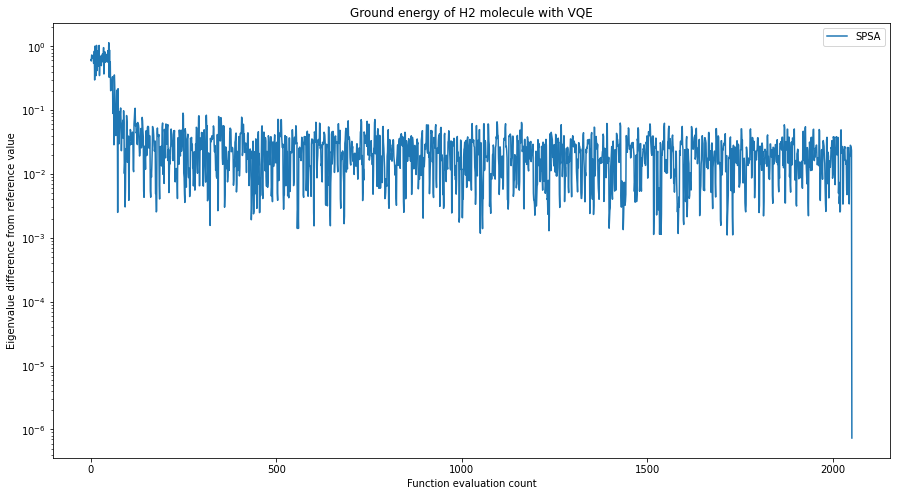

In [4]:
h2 = (-1.052373245772859 * I ^ I) + \
        (0.39793742484318045 * I ^ Z) + \
        (-0.39793742484318045 * Z ^ I) + \
        (-0.01128010425623538 * Z ^ Z) + \
        (0.18093119978423156 * X ^ X)

vqe_algorithm(h2, SPSA, 'statevector_simulator', 1000, 'Ground energy of H2 molecule with VQE')

As you can see, the VQE algorithm was able to produce accurate results using the `statevector_simulator` and a bit over 2000 function evaluations. Now, let's test the algorithm using the same Hamiltonian but with the `COBYLA` optimizer.

VQE Result:  -1.8572750238770332
Function evaluation count:  124
Numpy result:  -1.8572750302023786


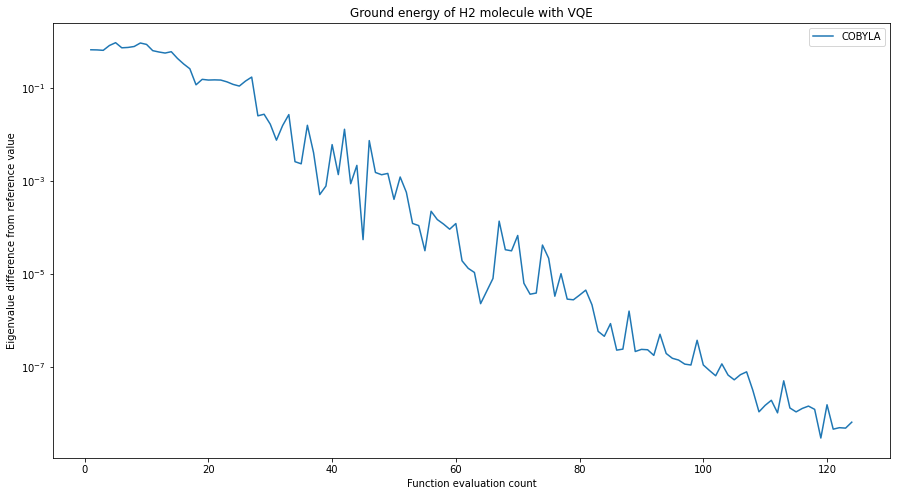

In [5]:
vqe_algorithm(h2, COBYLA, 'statevector_simulator', 1000, 'Ground energy of H2 molecule with VQE')

As you can see, this optimizer was able to produce equally (if not more) accurate results with only over 120 function evaluations. (You can read about this optimizer [here](https://cossan.co.uk/wiki/index.php/COBYLA).) We can keep experimenting with different optimzers, operators/Hamiltonians, and simulators to see which one performs better, but I believe that the explanation and examples above suffice to give a good understanding of the Variational Quantum Eigensolver algorithm.

**References**
- [1] https://qiskit.org/textbook/ch-applications/vqe-molecules.html
- [2] https://pennylane.ai/qml/demos/spsa.html
- [3] https://www.jhuapl.edu/spsa/PDF-SPSA/Spall_Implementation_of_the_Simultaneous.PDF